## Visualizing the results using tables and plots

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# getting the data from the output files after the calculations
nvda_data1_df = pd.read_csv("NVDA_outputData1.csv")
spy_data1_df = pd.read_csv("SPY_outputData1.csv")
vix_data1_df = pd.read_csv("^VIX_outputData1.csv")

In [ ]:
# using the downlaoded data for the spot price
df= pd.read_csv("options_data1.csv")
nvda_data1_spot = df.query('ticker == "NVDA"').iloc[1,-2]
spy_data1_spot = df.query('ticker == "SPY"').iloc[1,-2]

In [124]:
nvda_data1_spot
spy_data1_spot

603.619995

In [165]:
# Ensure Expiration is in datetime format
nvda_data1_df["Expiration"] = pd.to_datetime(nvda_data1_df["Expiration"])
spy_data1_df["Expiration"] = pd.to_datetime(spy_data1_df["Expiration"])
vix_data1_df["Expiration"] = pd.to_datetime(vix_data1_df['Expiration'])

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "SecantIV" , "ImpliedVolatility"]

# Function to get ATM IV for each expiration
def get_atm_row(df, spot_price):
    if df.empty:
        return None  # Return None if no matching expiration
    
    # Find ATM strike (closest to spot price)
    closest_strike = df.iloc[(df["Strike"] - spot_price).abs().argmin()]["Strike"]
    
    # Filter the row that matches the closest strike
    atm_row = df[df["Strike"] == closest_strike]
    
    
    return atm_row

# Apply the function to groupby object for each expiration
nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atm_iv = spy_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=spy_data1_spot).reset_index(drop=True)

# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2183801874.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2183801874.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data1_df.groupb

In [127]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,BisectionIV,NewtonIV,SecantIV,ImpliedVolatility
0,NVDA,2025-02-21,Call,132.0,0.458217,0.458217,0.458217,0.419684
1,NVDA,2025-02-21,Put,132.0,0.511800,0.511800,0.511800,0.453130
2,NVDA,2025-03-21,Call,132.0,0.586375,0.586375,0.586375,0.585942
3,NVDA,2025-03-21,Put,132.0,0.611904,0.611904,0.611904,0.578007
4,NVDA,2025-04-17,Call,130.0,0.532450,0.532450,0.532450,0.545293
5,NVDA,2025-04-17,Put,130.0,0.548353,0.548353,0.548353,0.517461
6,SPY,2025-02-21,Call,604.0,0.107713,0.107713,0.107713,0.103250
7,SPY,2025-02-21,Put,604.0,0.152178,0.152177,0.152177,0.129647
8,SPY,2025-03-21,Call,604.0,0.120918,0.120918,0.120918,0.134149
9,SPY,2025-03-21,Put,604.0,0.148769,0.148769,0.148769,0.129083


## average time for each method

In [ ]:
# function to calcu;late the average times for each methods
def compute_average_iv_time(df, ticker):
    avg_iv_table = (
        df.groupby(["Expiration"])[["BisectionTime","NewtonTime","SecantTime"]]
        .mean()
        .reset_index()
    )
    avg_iv_table["Ticker"] = ticker  # Add a column to distinguish NVDA vs SPY
    return avg_iv_table

nvda_average_iv_time_table = compute_average_iv_time(nvda_data1_df, "NVDA")
spy_average_iv_time_table = compute_average_iv_time(spy_data1_df, "SPY")

combined_average_iv_table = pd.concat([nvda_average_iv_time_table, spy_average_iv_time_table], ignore_index=True)

# Reorder columns to match the ATM IV table format
desired_columns = ["Ticker", "Expiration", "BisectionTime", "NewtonTime", "SecantTime"]
combined_average_iv_time_table = combined_average_iv_table[desired_columns]

In [141]:
combined_average_iv_time_table

,Ticker,Expiration,BisectionTime,NewtonTime,SecantTime
0,NVDA,2025-02-21,0.001476,0.000838,0.002160
1,NVDA,2025-03-21,0.002001,0.000832,0.001818
2,NVDA,2025-04-17,0.002959,0.001049,0.002240
3,SPY,2025-02-21,0.002120,0.001488,0.002750
4,SPY,2025-03-21,0.002696,0.001207,0.002349
5,SPY,2025-04-17,0.002504,0.001245,0.002750


In [128]:
desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "ImpliedVolatility"]

nvda_average_iv_table = nvda_data1_df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV", "ImpliedVolatility"]].mean().reset_index()
spy_average_iv_table = spy_data1_df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV", "ImpliedVolatility"]].mean()

#concat these tables
nvda_average_iv_table

,Expiration,OptionType,InTheMoney,BisectionIV,ImpliedVolatility
0,2025-02-21,Call,False,0.275367,4.213820
1,2025-02-21,Call,True,0.047756,0.219976
2,2025-02-21,Put,False,1.123846,1.788257
3,2025-02-21,Put,True,0.295309,0.475116
4,2025-03-21,Call,False,0.249491,2.737434
5,2025-03-21,Call,True,0.180797,1.006442
6,2025-03-21,Put,False,0.954504,0.942719
7,2025-03-21,Put,True,0.409862,0.369171
8,2025-04-17,Call,False,0.575801,0.576083
9,2025-04-17,Call,True,0.247414,1.064953


In [130]:
# Define a function to compute the average IV for a given DataFrame
def compute_average_iv(df, ticker):
    avg_iv_table = (
        df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV","NewtonIV","SecantIV", "ImpliedVolatility"]]
        .mean()
        .reset_index()
    )
    avg_iv_table["Ticker"] = ticker  # Add a column to distinguish NVDA vs SPY
    return avg_iv_table

# Compute average IV tables for NVDA and SPY
nvda_average_iv_table = compute_average_iv(nvda_data1_df, "NVDA")
spy_average_iv_table = compute_average_iv(spy_data1_df, "SPY")

# Concatenate the tables
combined_average_iv_table = pd.concat([nvda_average_iv_table, spy_average_iv_table], ignore_index=True)

# Reorder columns to match the ATM IV table format
desired_columns = ["Ticker", "Expiration", "OptionType", "InTheMoney", "BisectionIV", "NewtonIV", "SecantIV", "ImpliedVolatility"]
combined_average_iv_table = combined_average_iv_table[desired_columns]

In [131]:
combined_average_iv_table

,Ticker,Expiration,OptionType,InTheMoney,BisectionIV,NewtonIV,SecantIV,ImpliedVolatility
0,NVDA,2025-02-21,Call,False,0.275367,1.111634e+19,7.677880e+06,4.213820
1,NVDA,2025-02-21,Call,True,0.047756,1.487056e+277,2.135768e+08,0.219976
2,NVDA,2025-02-21,Put,False,1.123846,-1.587075e+209,3.883473e+01,1.788257
3,NVDA,2025-02-21,Put,True,0.295309,2.104426e+135,-2.268016e+07,0.475116
4,NVDA,2025-03-21,Call,False,0.249491,4.070811e+278,-4.445641e+06,2.737434
5,NVDA,2025-03-21,Call,True,0.180797,1.053362e+194,6.188715e+03,1.006442
6,NVDA,2025-03-21,Put,False,0.954504,-2.788038e+226,9.987531e-01,0.942719
7,NVDA,2025-03-21,Put,True,0.409862,2.103141e+236,3.519325e+05,0.369171
8,NVDA,2025-04-17,Call,False,0.575801,5.758007e-01,5.758007e-01,0.576083
9,NVDA,2025-04-17,Call,True,0.247414,-7.731962e+81,1.011495e+04,1.064953


In [67]:
# VIX table
# get VIX spot and its ATM options
vix_data1_spot = df[df["ticker"] == "^VIX"].iloc[0,-2]

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "ImpliedVolatility"]
vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)

vix_atm_iv = vix_atm_iv[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2482536726.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)


In [68]:
vix_data1_spot

15.9

In [69]:
vix_atm_iv

,Ticker,Expiration,OptionType,Strike,BisectionIV,NewtonIV,ImpliedVolatility
0,^VIX,2025-02-19,Call,16.0,1.632540,1.632540,1.419920
1,^VIX,2025-02-19,Put,16.0,0.242041,0.242040,0.218758
2,^VIX,2025-03-18,Call,16.0,1.261380,1.261380,1.238290
3,^VIX,2025-03-18,Put,16.0,0.382678,0.382679,0.365241
4,^VIX,2025-04-16,Call,16.0,1.185660,1.185660,1.184570
5,^VIX,2025-04-16,Put,16.0,0.374354,0.374354,0.352546


In [71]:
nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atm_iv = spy_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=spy_data1_spot).reset_index(drop=True)
vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "Bid", "Ask", "Parity_price"]


# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv, vix_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/4280825565.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/4280825565.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data1_df.groupby("

In [72]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,Bid,Ask,Parity_price
0,NVDA,2025-02-21 00:00:00,Call,132.0,3.45,3.50,3.886720
1,NVDA,2025-02-21 00:00:00,Put,132.0,4.05,4.10,3.683280
2,NVDA,2025-03-21 00:00:00,Call,132.0,9.75,9.80,10.294000
3,NVDA,2025-03-21 00:00:00,Put,132.0,9.90,10.00,9.576040
4,NVDA,2025-04-17 00:00:00,Call,130.0,12.80,12.90,13.340100
5,NVDA,2025-04-17 00:00:00,Put,130.0,10.50,10.60,10.189900
6,SPY,2025-02-21 00:00:00,Call,604.0,3.92,3.94,5.509720
7,SPY,2025-02-21 00:00:00,Put,604.0,5.32,5.35,3.740280
8,SPY,2025-03-21 00:00:00,Call,604.0,10.22,10.25,12.324700
9,SPY,2025-03-21 00:00:00,Put,604.0,10.18,10.21,8.125340


## Plot for implied volatility

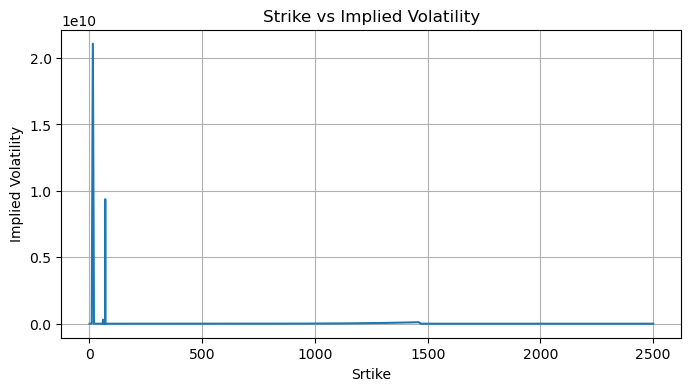

In [111]:
# NVDA call
expirations = nvda_data1_df["Expiration"].unique()

nvda_call_df = nvda_data1_df[nvda_data1_df["OptionType"] == "Call"]
nvda_call_df = nvda_call_df.loc[nvda_call_df["Expiration"] == expirations[0]]

plt.figure(figsize=(8, 4))
plt.plot(nvda_call_df["Strike"], nvda_call_df["SecantIV"])

# Labels and Title
plt.xlabel("Srtike")
plt.ylabel("Implied Volatility")
plt.title("Strike vs Implied Volatility")
plt.grid(True)  # Add grid lines

# Show the plot
plt.show()

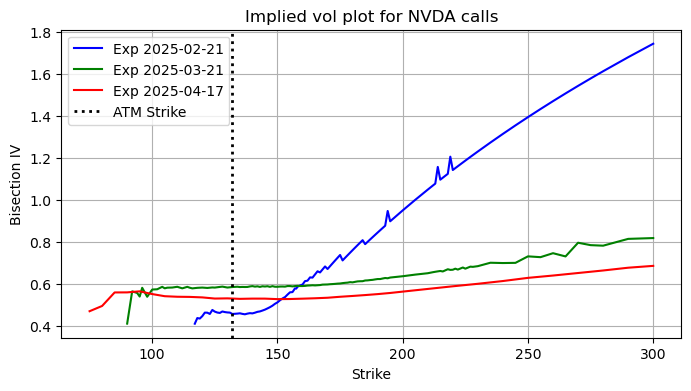

In [158]:
# Filter Calls first
nvda_call_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["NewtonIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["NewtonIV"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["NewtonIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Implied vol plot for NVDA calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()


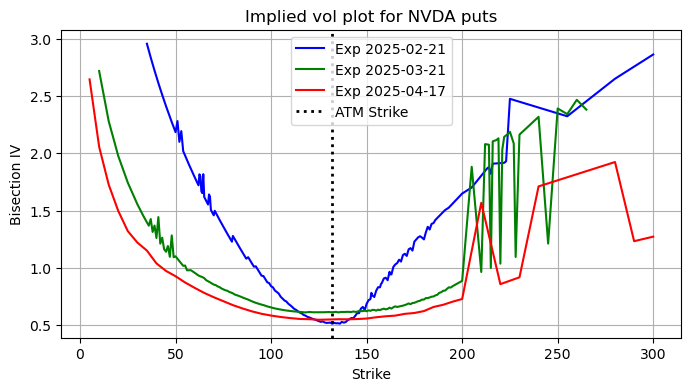

In [159]:
# Filter Puts first
nvda_put_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
nvda_put_df1 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[0]) & (nvda_put_df["BisectionIV"] > 0.0001)]
nvda_put_df2 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[1]) & (nvda_put_df["BisectionIV"] > 0.0001)]
nvda_put_df3 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[2]) & (nvda_put_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_put_df1["Strike"], nvda_put_df1["BisectionIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_put_df2["Strike"], nvda_put_df2["BisectionIV"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_put_df3["Strike"], nvda_put_df3["BisectionIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Implied vol plot for NVDA puts")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()


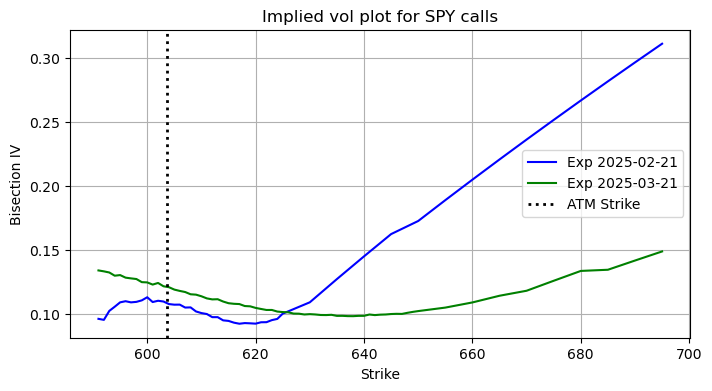

In [160]:
# Filter Calls first
spy_call_df = spy_data1_df.loc[spy_data1_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["BisectionIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["BisectionIV"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["BisectionIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()


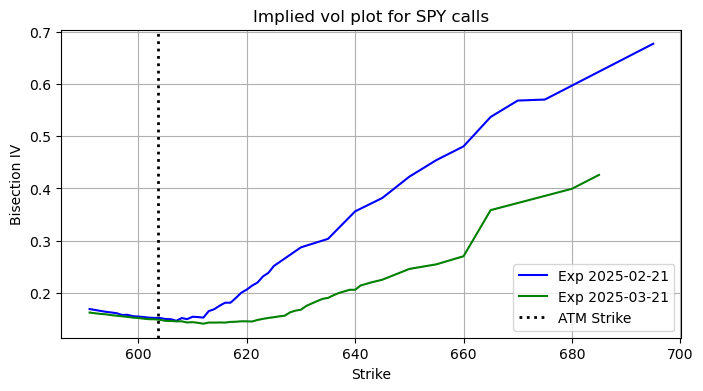

In [163]:
# Filter puts first
spy_call_df = spy_data1_df.loc[spy_data1_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["BisectionIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["BisectionIV"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["BisectionIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

## Greeks Table

In [167]:
nvda_atms = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atms = spy_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=spy_data1_spot).reset_index(drop=True)
vix_atms = vix_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=vix_data1_spot).reset_index(drop=True)

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "Delta_bs","Gamma_bs","Vega_bs","Delta_fd","Gamma_fd","Vega_fd"]

# Combine both NVDA and SPY data into a single table
atm_table = pd.concat([nvda_atms, spy_atms, vix_atms], ignore_index=True)
atm_table = atm_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2320097676.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atms = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2320097676.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atms = spy_data1_df.groupby("Exp

In [168]:
atm_table

,Ticker,Expiration,OptionType,Strike,Delta_bs,Gamma_bs,Vega_bs,Delta_fd,Gamma_fd,Vega_fd
0,NVDA,2025-02-21,Call,132.0,0.505353,0.044651,7.777480,0.505353,0.044651,7.777480
1,NVDA,2025-02-21,Put,132.0,-0.492209,0.039972,7.776690,-0.492209,0.039972,7.776690
2,NVDA,2025-03-21,Call,132.0,0.540679,0.016364,16.414100,0.540679,0.016365,16.414100
3,NVDA,2025-03-21,Put,132.0,-0.457897,0.015676,16.407900,-0.457897,0.015675,16.407900
4,NVDA,2025-04-17,Call,130.0,0.580100,0.013417,21.385900,0.580100,0.013417,21.385900
5,NVDA,2025-04-17,Put,130.0,-0.419646,0.013026,21.383100,-0.419646,0.013027,21.383100
6,SPY,2025-02-21,Call,604.0,0.510629,0.041431,35.638500,0.510629,0.041433,35.638500
7,SPY,2025-02-21,Put,604.0,-0.490234,0.029327,35.640500,-0.490234,0.029327,35.640500
8,SPY,2025-03-21,Call,604.0,0.544699,0.017295,75.152000,0.544699,0.017295,75.152000
9,SPY,2025-03-21,Put,604.0,-0.460495,0.014077,75.256100,-0.460495,0.014077,75.256100


## DATA2 BS price vs Observed

In [ ]:
# getting data for Day 2 after the calculations
nvda_data2_df = pd.read_csv("NVDA_outputData2.csv")
spy_data2_df = pd.read_csv("SPY_outputData2.csv")
vix_data2_df = pd.read_csv("^VIX_outputData2.csv")

df= pd.read_csv("options_data2.csv")
nvda_data2_spot = df.query('ticker == "NVDA"').iloc[1,-2]
spy_data2_spot = df.query('ticker == "SPY"').iloc[1,-2]
vix_data2_spot = df.query('ticker == "^VIX"').iloc[0,-2]

In [ ]:
# getting all the ATM strikes from each option type and expirations
nvda_atms2 = nvda_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data2_spot).reset_index(drop=True)
spy_atms2 = spy_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=spy_data2_spot).reset_index(drop=True)
vix_atms2 = vix_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=vix_data2_spot).reset_index(drop=True)

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "Bs_price","Bid","Ask"]

# Combine both NVDA and SPY data into a single table
atm_table2 = pd.concat([nvda_atms2, spy_atms2, vix_atms2], ignore_index=True)
atm_table2 = atm_table2[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/3990273545.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atms2 = nvda_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data2_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/3990273545.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atms2 = spy_data2_df.groupby("E

In [184]:
atm_table2

,Ticker,Expiration,OptionType,Strike,Bs_price,Bid,Ask
0,NVDA,2025-02-21,Call,135.0,3.364750,3.80,3.85
1,NVDA,2025-02-21,Put,135.0,3.916600,3.00,3.05
2,NVDA,2025-03-21,Call,135.0,9.771330,10.50,10.60
3,NVDA,2025-03-21,Put,135.0,10.092900,9.20,9.35
4,NVDA,2025-04-17,Call,135.0,11.827200,12.60,12.70
5,NVDA,2025-04-17,Put,135.0,11.975400,10.95,11.05
6,SPY,2025-02-21,Call,606.0,3.699340,5.00,5.02
7,SPY,2025-02-21,Put,606.0,4.907270,3.48,3.50
8,SPY,2025-03-21,Call,606.0,9.442740,11.41,11.45
9,SPY,2025-03-21,Put,606.0,10.332800,8.51,8.53
